# Индекс новостей

In [3]:
import numpy as np
import pandas as pd
import datetime
import os

import pickle

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')

from tqdm import tqdm as tqdm_notebook

from collections import defaultdict

%matplotlib inline

In [4]:
krizis = set(['банк', 'курс', 'доллар', 'евро', 'цб', 'ртс', 'ммвб',  'ипотека', 'акция',
          'кредит', 'пиф', 'банкротство', 'залог', 'дефолт', 'девальвация','финансовый', 'кризис'])

[Сентимент-словарь с корпоры](https://github.com/dkulagin/kartaslov)

In [5]:
url = "https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/emo_dict/emo_dict.csv"
df = pd.read_csv(url, sep=';')

# словарик негатива
terms = df[df.tag == 'NGTV'][['term','value']]
negative_dict_corpora_v1 = dict(zip(terms.term.values, terms.value.values))

# словарик позитива 
terms = df[df.tag == 'PSTV'][['term','value']]
positive_dict_corpora_v1 = dict(zip(terms.term.values, terms.value.values))

In [6]:
negative_dict = negative_dict_corpora_v1
positive_dict = positive_dict_corpora_v1

In [7]:
drop = """вирус
инфекция
заразиться
заболевание
заражение
умереть
карантин
заболеть
заразить
эпидемия
пневмония
болезнь
инфекционный
карантинный
изоляция
грипп
осложнение
госпитализация
вирусный
обострение
заболеваемость"""

for item in drop.split():
    del negative_dict[item]

In [8]:
def neg_ind(w):
    scores = [negative_dict.get(item.split("_")[0], 0) for item in w]
    return sum(scores)

def pos_ind(w):
    scores = [positive_dict.get(item.split("_")[0], 0) for item in w]
    return np.mean(scores)

# Подсчёт дескрипторов по датам и источникам


```

{

(дата, категория, источник) : {
                               всего статей: частота, 
                               токен: частота
                               }
}

```

In [ ]:
def zero_add(obj):
    obj = str(obj)
    if len(obj) == 1:
        return '0' + obj
    else:
        return obj

In [ ]:
words_dct = dict( )

In [ ]:
for i,source in enumerate(['rbc', 'lenta', 'interfax', 'tass', 'ria']):
    
    print(source)

    path = f"../01_Сборщик_новостей/news_data/{i + 1}.{source}/lemm/"
    files = os.listdir(path)

    for jtem in files:

        with open(path + jtem, 'rb') as f:
            data = pickle.load(f)

        for item in tqdm_notebook(data):

            if source in ['rbc', 'tass', 'ria']:
                dt = item['date'][:10]
                category = item.get('category', 'not_category')

            elif source in ['lenta']:
                dt = str(item['year']) + '-' + zero_add(item['month']) + '-' + zero_add(item['day'])
                category = item.get('rubrics', 'not_category')            

            elif source in ['interfax']:
                dt = str(item['year']) + '-' + zero_add(item['month']) + '-' + zero_add(item['day'])
                category = item['href'].split("/")[1]


            obj = (dt, category, source)

            if obj not in words_dct:
                words_dct[obj] = defaultdict(lambda:0)

            tokens = set([w.split("_")[0] for w in item['title']] + [w.split("_")[0] for w in item['text']])
            exist_token = tokens & krizis


            words_dct[obj]['total_cnt'] += 1
            words_dct[obj]['krzis_cnt'] += (len(exist_token) > 0)

            # Блок с сентиментом
            words_dct[obj]['title_neg'] += neg_ind(item['title'])
            words_dct[obj]['text_neg']  += neg_ind(item['text'])

            words_dct[obj]['title_neg_len'] += neg_ind(item['title'])/(len(item['title']) + 1e-4)
            words_dct[obj]['text_neg_len']  += neg_ind(item['text'])/(len(item['text']) + 1e-4)

            words_dct[obj]['title_pos'] +=  pos_ind(item['title'])
            words_dct[obj]['text_pos']  +=  pos_ind(item['text'])

            words_dct[obj]['title_pos_len'] +=  pos_ind(item['title'])/(len(item['title']) + 1e-4)
            words_dct[obj]['text_pos_len']  +=  pos_ind(item['text'])/(len(item['text']) + 1e-4)

            for tok in exist_token:
                words_dct[obj][tok] += 1


rbc


In [ ]:
len(words_dct)

In [ ]:
words_dct = {k : dict(v) for k,v in words_dct.items()}

In [ ]:
len(words_dct)

In [ ]:
with open("news_tokens_cnt.pickle", 'wb') as f:
    pickle.dump(words_dct, f)

# Агрегация по дням

In [9]:
def index_make(df_term):
    corr_matrix = df_term.corr()
    w = np.array(corr_matrix.sum()/corr_matrix.sum().sum())
    print(w)
    index = (np.array(df_term).T*w.reshape(len(w),1)).sum(axis = 0)
    return index

def min_max_scaler(df, col):
    mx = df[col].max()
    mn = df[col].min()
    df[col] = 100*(df[col] - mn)/(mx - mn)
    pass

In [10]:
with open("news_tokens_cnt.pickle", 'rb') as f:
    words_dct = pickle.load(f)

In [11]:
df = pd.DataFrame(words_dct)
df = df.T

df.reset_index(inplace=True)
df.columns = ['date', 'category', 'source'] + list(df.columns[3:])

df.head()

,date,category,source,total_cnt,krzis_cnt,title_neg,text_neg,title_neg_len,text_neg_len,title_pos,...,курс,цб,кредит,девальвация,ммвб,банкротство,пиф,залог,ипотека,ртс
0,2015-12-31,Украинский кризис,rbc,3.0,1.0,-0.8838,-10.9242,-0.149802,-0.059039,0.268680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-31,Общество,rbc,17.0,2.0,-14.6225,-87.0717,-1.631777,-0.949701,0.439488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-31,Бизнес,rbc,7.0,2.0,-1.1157,-15.8328,-0.181377,-0.112710,0.337683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-31,Политика,rbc,13.0,1.0,-12.2269,-94.5998,-1.372052,-0.577064,0.848779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-31,Санкции против Турции,rbc,2.0,0.0,-1.0000,-8.1488,-0.111110,-0.034357,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.source.unique()

array(['rbc', 'lenta', 'interfax', 'tass', 'ria'], dtype=object)

In [13]:
df[df.source == 'lenta'].category.value_counts()[:50]

world        4749
russia       4748
sport        4712
ussr         4667
culture      4564
science      4398
media        4387
economics    4306
forces       2676
Name: category, dtype: int64

In [25]:
#usl = (df.source == 'rbc')

#usl = (df.source == 'ria')&( df.category.apply(lambda w: w in ['Экономика', 'Политика']))
#usl = (df.source == 'ria')

# usl = (df.source == 'tass')&( df.category.apply(lambda w: w in ['Экономика и бизнес','Малый бизнес', 'Политика']))
# usl = (df.source == 'tass')

# usl = (df.source == 'interfax')&( df.category.apply(lambda w: w in ['russia','business']))
# usl = (df.source == 'interfax')

# usl = (df.source == 'lenta')&( df.category.apply(lambda w: w in ['russia', 'economics']))
usl = (df.source == 'lenta')

In [26]:
df_cur = df[usl]
df_cur.head()

,date,category,source,total_cnt,krzis_cnt,title_neg,text_neg,title_neg_len,text_neg_len,title_pos,...,курс,цб,кредит,девальвация,ммвб,банкротство,пиф,залог,ипотека,ртс
34312,2008-01-01,russia,lenta,11.0,2.0,-8.1350,-79.3209,-1.189147,-0.665773,0.837316,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
34313,2008-01-01,world,lenta,12.0,5.0,-7.9461,-98.2590,-1.074848,-0.615486,0.885867,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34314,2008-01-01,economics,lenta,2.0,2.0,0.0000,-1.9194,0.000000,-0.006665,0.160717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34315,2008-01-01,sport,lenta,1.0,0.0,0.0000,-3.0756,0.000000,-0.021659,0.257650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34316,2008-01-01,culture,lenta,1.0,1.0,0.0000,-7.2165,0.000000,-0.026827,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_cur.total_cnt.sum()

589519.0

In [28]:
df_cur = df[usl]
df_cur.loc[:,'date'] = df_cur['date'].apply(lambda w: w[:7]).values
df_cur = df_cur[df_cur['date'].apply(lambda w: '-' in w)]

df_cur = df_cur[df_cur['date'].apply(lambda w: w not in ['2020-06', '2020-07', '2020-08', '2020-09', \
                                                         '2020-10', '2020-11', '2020-12'])]

neg = ['title_neg', 'text_neg', 'title_neg_len', 'text_neg_len', 
       'title_pos', 'text_pos', 'title_pos_len', 'text_pos_len']

col = ['krzis_cnt', 'total_cnt'] + list(krizis) 
df_agg = df_cur.groupby('date')[col].sum().sort_index()
df_agg2 = df_cur.groupby('date')[neg].mean().sort_index()
df_agg = df_agg.join(df_agg2)
df_agg.head()

,krzis_cnt,total_cnt,банк,курс,дефолт,девальвация,ртс,пиф,банкротство,кризис,...,залог,кредит,title_neg,text_neg,title_neg_len,text_neg_len,title_pos,text_pos,title_pos_len,text_pos_len
date,,,,,,,,,,,,,,,,,,,,,
2008-01,921.0,2940.0,165.0,70.0,4.0,1.0,0.0,6.0,11.0,75.0,...,23.0,40.0,-6.314346,-65.332070,-0.900093,-0.435623,0.867260,0.665094,0.136770,0.005323
2008-02,1071.0,3519.0,157.0,66.0,2.0,0.0,0.0,3.0,11.0,54.0,...,23.0,32.0,-7.575638,-77.904172,-1.104292,-0.541547,1.050298,0.813364,0.166860,0.006558
2008-03,1183.0,3804.0,183.0,80.0,2.0,1.0,0.0,6.0,24.0,87.0,...,34.0,40.0,-7.676868,-82.550296,-1.092491,-0.553653,1.066659,0.843993,0.166824,0.006860
2008-04,1229.0,3866.0,180.0,92.0,0.0,0.0,0.0,5.0,23.0,102.0,...,30.0,45.0,-7.515425,-83.406248,-1.077738,-0.536493,1.110225,0.873866,0.176681,0.006676
2008-05,993.0,3533.0,157.0,76.0,1.0,2.0,0.0,3.0,18.0,85.0,...,16.0,49.0,-7.045437,-73.512485,-1.013246,-0.483468,0.970613,0.757127,0.152008,0.005741


In [29]:
df_index = pd.DataFrame( )

# Доля кризисных статей за день
ind = (df_agg['krzis_cnt']/(df_agg['total_cnt'] + 1e-4))
df_index['date'] = ind.index
df_index['krizis_share'] = ind.values
df_index['total_cnt'] = df_agg['total_cnt'].values
df_index.set_index('date', inplace=True)
min_max_scaler(df_index, 'krizis_share')

ind = index_make(df_agg[list(krizis)])/1000
df_index['krizis_corr'] = ind 
min_max_scaler(df_index, 'krizis_corr')

# Слова с негативом и позитивом с суммами-хуюммами :) 
df_index['negative'] = df_agg['title_neg'] + df_agg['text_neg']
min_max_scaler(df_index, 'negative')

df_index['negative_len'] = df_agg['title_neg_len'] + df_agg['text_neg_len'] 
min_max_scaler(df_index, 'negative_len')

df_index['diff'] =  df_agg['title_neg'] + df_agg['text_neg'] + \
                    df_agg['title_pos'] + df_agg['text_pos']
min_max_scaler(df_index, 'diff')

df_index['diff_len'] = df_agg['title_neg_len'] + df_agg['text_neg_len'] + \
                       df_agg['title_pos_len'] + df_agg['text_pos_len']
min_max_scaler(df_index, 'diff_len')

[0.08624661 0.04607166 0.03624053 0.0574197  0.         0.03476219
 0.07602276 0.08593944 0.0144857  0.07976842 0.04257651 0.06882225
 0.09106781 0.08321851 0.0558704  0.05829625 0.08319127]


In [30]:
df_index.head()

,krizis_share,total_cnt,krizis_corr,negative,negative_len,diff,diff_len
date,,,,,,,
2008-01,68.663647,2940.0,25.878480,90.053092,62.349792,90.239725,63.237520
2008-02,64.728416,3519.0,29.773374,83.330602,42.308640,83.613101,43.524571
2008-03,67.658878,3804.0,37.295469,81.023573,42.288901,81.306232,43.521735
2008-04,70.708752,3866.0,41.270996,80.686069,44.351226,81.001420,46.462197
2008-05,54.453508,3533.0,30.190437,85.722448,51.945539,85.961983,52.960831


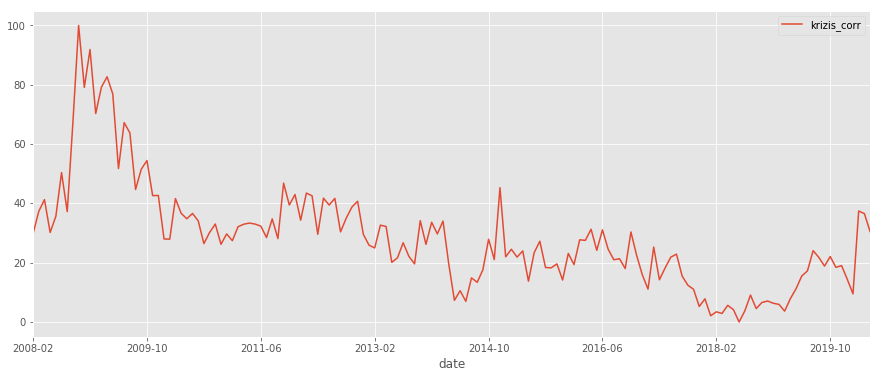

In [31]:
df_index[1:][[
    #'krizis_share',
    'krizis_corr',
    #'negative',
    #'negative_len',
    #'diff'
         ]].plot(legend=True, figsize=(15,6));

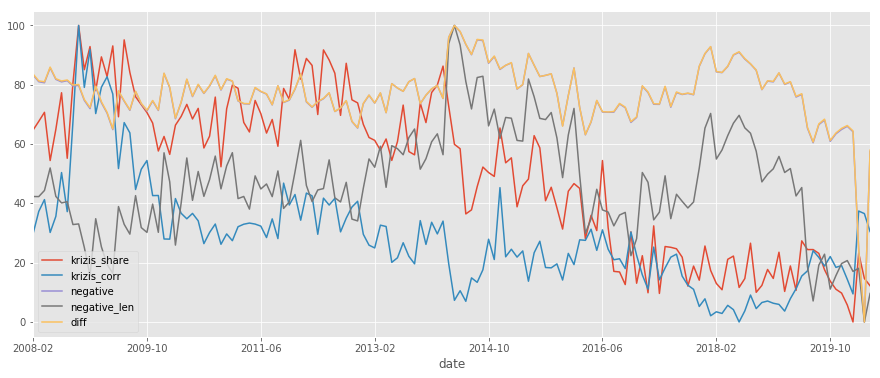

In [32]:
df_index[1:][[
    'krizis_share',
    'krizis_corr',
    'negative',
    'negative_len',
    'diff'
         ]].plot(legend=True, figsize=(15,6));

In [33]:
df_index.reset_index(inplace=True)

df_index.columns = ['fielddate', 'newsInd_krizis_share', 'total_cnt', 'newsInd_krizis_corr', 
                    'newsInd_krizis_neg', 'newsInd_krizis_neg_len', 
                    'newsInd_krizis_diff', 'newsInd_krizis_diff_len']

# df_index.to_csv('../Индексы/data_simple_index_v2/news_krizis_index_month.tsv', sep="\t", index=None)
df_index.to_csv('data_simple_index_v2/news_krizis_index_month_lenta_all.tsv', sep="\t", index=None)

In [34]:
df_index

,fielddate,newsInd_krizis_share,total_cnt,newsInd_krizis_corr,newsInd_krizis_neg,newsInd_krizis_neg_len,newsInd_krizis_diff,newsInd_krizis_diff_len
0,2008-01,68.663647,2940.0,25.878480,90.053092,62.349792,90.239725,63.237520
1,2008-02,64.728416,3519.0,29.773374,83.330602,42.308640,83.613101,43.524571
2,2008-03,67.658878,3804.0,37.295469,81.023573,42.288901,81.306232,43.521735
3,2008-04,70.708752,3866.0,41.270996,80.686069,44.351226,81.001420,46.462197
4,2008-05,54.453508,3533.0,30.190437,85.722448,51.945539,85.961983,52.960831
...,...,...,...,...,...,...,...,...
144,2020-01,5.721681,4788.0,14.373846,65.996314,20.715611,66.260154,20.816698
145,2020-02,0.000000,4668.0,9.468894,64.165682,17.054403,64.430440,16.263479
146,2020-03,23.179665,5414.0,37.417694,24.508889,18.118072,24.527894,18.171717
147,2020-04,14.678478,6065.0,36.548228,0.000000,0.000000,0.000000,0.000000


In [35]:
df_index.total_cnt.sum()

542813.0